In [1]:
from influxdb import InfluxDBClient
client = InfluxDBClient(host='140.112.42.158', port=8086, database='test')

In [2]:
query = "SELECT SAMPLE(\"viewer\",1), ip_list, num_edge FROM /.*/ WHERE stream_language = 'zh-tw' AND time >= '2019-10-14T12:00:00Z' AND time <= '2019-10-14T14:00:00Z'" 
result = client.query(query)

In [3]:
edge_load = dict()
edge_hosted_channels = dict()

for (channel, _), point in zip(result.keys(), list(result.get_points())):
    vc = point['sample'] / point ['num_edge'] # viewer count = num of viewer / num of edge servers
    for edge in point['ip_list'].split(','):
        edge_load[edge] = edge_load.get(edge, 0) + vc 
        edge_hosted_channels.setdefault(edge,[]).append((channel, int(vc)))

In [4]:
summary = list()
for k, v in edge_load.items():
    summary.append((k, v, len(edge_hosted_channels[k])))

In [5]:
summary = sorted(summary, key = lambda x:  x[1], reverse=True)
edges, load, channels = [list(x) for x in zip(*summary)]
N = len(load)

In [12]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors

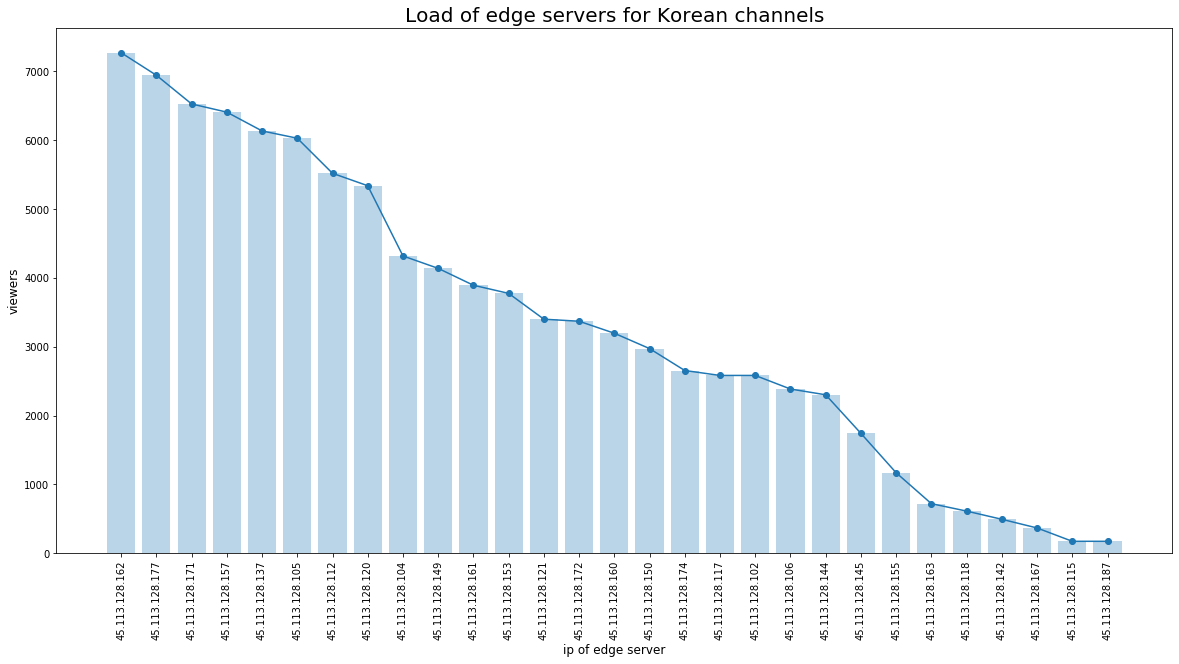

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
x = list(range(N))

ax.plot(x, load, marker='o')
# for _x, _y in enumerate(load):
#    ax.text(_x-0.5, int(_y), f'{int(_y)}', color='blue', rotation='vertical')
ax.set_xlabel('ip of edge server', fontsize=12)
ax.set_ylabel('viewers', fontsize=12)
plt.bar(x, load, alpha=0.3)
plt.xticks(x, edges, rotation='vertical')
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.title('Load of edge servers for Korean channels', fontsize=20)
plt.show()

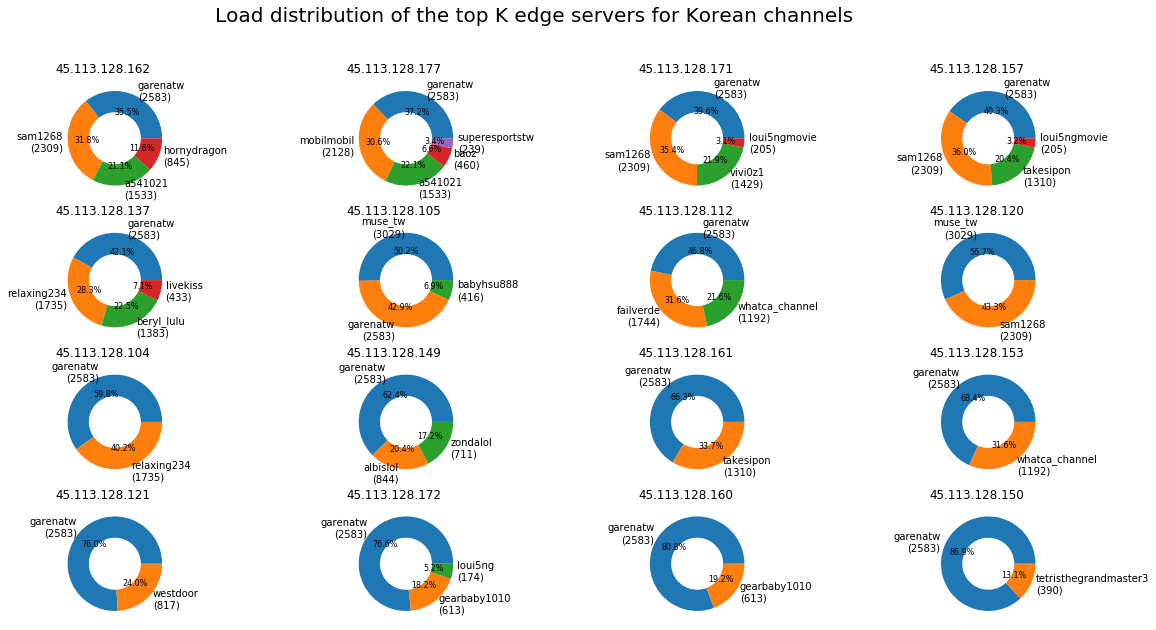

In [53]:
"""
def get_percentage(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)
"""
def get_percentage(pct):
    return f'{pct:.1f}%'

fig, ax = plt.subplots(figsize=(20, 10), nrows=4, ncols=4)
fig.suptitle('Load distribution of the top K edge servers for Korean channels', fontsize=20)

i = 0
for _x, row in enumerate(ax):
    for _y, col in enumerate(row):
        ip, data = edges[i], sorted(edge_hosted_channels[edges[i]], key = lambda x:  x[1], reverse=True)
        channels, viewers = [list(x) for x in zip(*data)]
        channels = [f'{x[0]}\n({x[1]})' for x in zip(channels, viewers)] 
        # wedges, texts, autotexts = ax[_x, _y].pie(viewers, labels=channels, autopct=lambda pct: get_percentage(pct, viewers), textprops=dict(color="black"), wedgeprops=dict(width=0.45))
        wedges, texts, autotexts = ax[_x, _y].pie(viewers, labels=channels, autopct=lambda pct: get_percentage(pct), textprops=dict(color="black"), wedgeprops=dict(width=0.45))
        # ax[_x, _y].legend(wedges, channels, title="Channels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)
        plt.setp(autotexts, size=8)
        ax[_x, _y].set_title(f"{ip}", fontsize=12, loc='left')  
        i += 1
plt.show()